## COMP5625M Assessment 1 - Image Classification [100 marks]

<div class="logos"><img src="https://drive.google.com/uc?id=132BXgkV5w1bpXlVpdr5BtZdpagqYvna7" width="220px" align="right"></div>

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this assessment, you will gain practical experience in:

> 1. Implementing and evaluating a multi-layer perceptron (MLP) and convolutional neural network (CNN) in solving a classification problem
> 2. Building, evaluating, and finetuning a CNN on an image dataset from development to testing 
> 3. Tackling overfitting using strategies such as data augmentation and drop out
> 4. Fine tuning a model 
> 5. Comparing the performance of a new model with an off-the-shelf model (AlexNet)
> 6. Gaining a deeper understanding of model performance using visualisations from Grad-CAM.


### Setup and resources 

You must work using this template notebook.

Having a GPU will speed up the training process. See the provided document on Minerva about setting up a working environment for various ways to access a GPU. We highly recommend you use platforms such as Colab.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This coursework will use a subset of images from Tiny ImageNet, which is a subset of the [ImageNet dataset](https://www.image-net.org/update-mar-11-2021.php). Our subset of Tiny ImageNet contains **30 different categories**, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from a direct link or the Kaggle challenge website:

>[Direct access to data is possible by clicking here, please use your university email to access this](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/ESF87mN6kelIkjdISkaRow8BublW27jB-P8eWV6Rr4rxtw?e=SPASDB)

>[Access data through Kaggle webpage](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07) 


### Required submissions

##### 1. Kaggle Competition
To participate in the submission of test results, you will need an account. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb``.

The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard. [Link to submit your results on Kaggle competition](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/submissions). 

Please submit only your predictions from test set - detailed instructions are provided in (3)

##### 2. Submission of your work

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected image from section 2.4.2 "Failure analysis".

**Final note:**

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.



Your student username (for example, ```sc15jb```):

mm22nk

Your full name:

Nilesh Kumar

## Required packages

[1] [numpy](http://www.numpy.org) is a package for scientific computing with python

[2] [h5py](http://www.h5py.org) is a package to interact with compactly stored dataset

[3] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[4] [pytorch](https://pytorch.org/docs/stable/index.html) is a library widely used for bulding deep-learning frameworks

Feel free to add to this section as needed - examples of importing libraries are provided below.

You may need to install these packages using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [57]:
import math
import os
import torch
import time
import numpy as np
import pandas as pd
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
from torch import optim
import torch.nn.functional as F
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
!pip install natsort
from natsort import natsorted

In [59]:
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview:**

**1. Function implementation** (12 marks)

*   **1.1** PyTorch ```Dataset``` and ```DataLoader``` classes (4 marks)
*   **1.2** PyTorch ```Model``` class for a simple MLP model (4 marks)
*   **1.3** PyTorch ```Model``` class for a simple CNN model (4 marks)

**2. Model training** (20 marks)
*   **2.1** Train on TinyImageNet30 dataset (7 marks)
*   **2.2** Generate confusion matrices and ROC curves (4 marks)
*   **2.3** Strategies for tackling overfitting (9 marks)
    *   **2.3.1** Data augmentation
    *   **2.3.2** Dropout
    *   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)
            

**3. Model Fine-tuning on CIFAR10 dataset** (20 marks)
*   **3.1** Fine-tune your model (initialise your model with pretrained weights from (2)) (8 marks)
*   **3.2** Fine-tune model with frozen base convolution layers (8 marks)
*   **3.3** Compare complete model retraining with pretrained weights and with frozen layers. Comment on what you observe? (4 marks) 

**4. Model testing** (18 marks)
*   **4.1**   Test your final model in (2) on test set - code to do this (10 marks)
*   **4.2**   Upload your result to Kaggle  (8 marks)

**5. Model comparison** (14 marks)
*   **5.1**   Load pretrained AlexNet and finetune on TinyImageNet30 until model convergence (6 marks)
*   **5.2**   Compare the results of your CNN model with pretrained AlexNet on the same validation set. Provide performance values (loss graph, confusion matrix, top-1 accuracy, execution time) (8 marks)

**6. Interpretation of results** (16 marks)
*   **6.1** Use grad-CAM on your model and on AlexNet (6 marks)
*   **6.2** Visualise and compare the results from your model and from AlexNet (4 marks)
*   **6.3** Comment on (6 marks):
    - why the network predictions were correct or not correct in your predictions? 
    - what can you do to improve your results further?

## 1 Function implementations [12 marks]


### 1.1 Dataset class [4 marks]

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.

In [60]:
all_classes = []
class loadCustomData(Dataset):
  def __init__(self, main_dir, transform):
    self.main_dir = main_dir
    self.transform = transform
    self.image_paths = []
    self.labels = []
    all_classes = sorted(os.listdir(main_dir))
    self.classes = all_classes
    self.label_to_cn = {}
    for i,label in enumerate(all_classes):
      self.label_to_cn[label] = i
      label_path = os.path.join(self.main_dir, label)
      if os.path.isdir(label_path):
        for image_name in os.listdir(label_path):
          image_path = os.path.join(label_path, image_name)
          self.image_paths.append(image_path)
          self.labels.append(label)

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, index):
    image_path = self.image_paths[index]
    im = plt.imread(image_path)
    if len(im.shape) == 2:
        im=torch.from_numpy(im)
        im=torch.stack([im,im,im],0)
        im=torch.transpose(im,0,2)
        im=im.numpy()
    transformed_image = self.transform(im)
    label = self.labels[index]
    label = torch.tensor(self.label_to_cn[self.labels[index]])
    return transformed_image, label

In [116]:
dataset = loadCustomData(r'/kaggle/input/comp5623m-artificial-intelligence/train_set/train_set/train_set', transform=transforms.ToTensor())
torch.manual_seed(0)
train_size = int(0.8*len(dataset))
validation_size = int(len(dataset) - train_size)
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
validation_loader = DataLoader(validation_dataset, batch_size = 32, shuffle = False)
classes = dataset.classes

### 1.2 Define a MLP model class [4 marks]

<u>Create a new model class using a combination of:</u>
- Input Units
- Hidden Units
- Output Units
- Activation functions
- Loss function
- Optimiser

In [63]:
class mlpClassifier(nn.Module):
    def __init__(self, lr):
        super(mlpClassifier, self).__init__()
        self.input_fc = nn.Linear(3*64*64, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, 30)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr =lr, momentum = 0.9)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        h_1 = F.relu(self.input_fc(x))
        h_2 = F.relu(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)
        return y_pred
net_mlp = mlpClassifier(0.01)

mlpClassifier(
  (input_fc): Linear(in_features=12288, out_features=250, bias=True)
  (hidden_fc): Linear(in_features=250, out_features=100, bias=True)
  (output_fc): Linear(in_features=100, out_features=30, bias=True)
  (criterion): CrossEntropyLoss()
)
torch.Size([250, 12288])
torch.Size([250])
torch.Size([100, 250])
torch.Size([100])
torch.Size([30, 100])
torch.Size([30])


### 1.3 Define a CNN model class [4 marks]

<u>Create a new model class using a combination of:</u>
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers 
- Loss function
- Optimiser

In [64]:
class cnnClassifier(nn.Module):
    def __init__(self,lr):
        super(cnnClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 30)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr = lr, momentum = 0.9)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        return x
net_cnn = cnnClassifier(0.01)

cnnClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=512, out_features=30, bias=True)
  (criterion): CrossEntropyLoss(

## 2 Model training [20 marks]


### 2.1 Train both MLP and CNN models - show loss and accuracy graphs side by side [7 marks]

Train your model on the TinyImageNet30 dataset. Split the data into train and validation sets to determine when to stop training. Use seed at 0 for reproducibility and test_ratio=0.2 (validation data)

Display the graph of training and validation loss over epochs and accuracy over epochs to show how you determined the optimal number of training epochs. Top-*k* accuracy implementation is provided for you below.

> Please leave the graph clearly displayed. Please use the same graph to plot graphs for both train and validation.


In [65]:
def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    n = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            running_loss += net.criterion(outputs, labels)
            n += 1
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0) 
            correct += (predicted == labels).sum().item()  
    return running_loss/n, correct/total 

In [66]:
def model_train(model,name,nepochs,train_loader,valid_loader):
    print('Training started.......')
    net = model
    results_path = f'/kaggle/working/{name}{nepochs}epochs.pt'
    start_time = time.time()
    statsrec = np.zeros((4,nepochs))
    best_acc = 0
    best_epoch = 0
    stop_training = False
    for epoch in range(nepochs):  
        correct = 0      
        total = 0          
        running_loss = 0.0   
        n = 0             
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            net.optimizer.zero_grad()
            outputs = net(inputs)
            loss = net.criterion(outputs, labels)
            loss.backward()
            net.optimizer.step()
            running_loss += loss.item()
            n += 1
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        ltrn = running_loss/n
        atrn = correct/total 
        ltst, atst = stats(valid_loader, net)  
        statsrec[:,epoch] = torch.tensor([ltrn,atrn , ltst, atst]).cpu()
        print(f"{device} | epoch: {epoch}/{nepochs} train_loss: {ltrn: .3f} train_accuracy: {atrn: .1%}  test_loss: {ltst: .3f} test_accuracy: {atst: .1%}")
        if atst > best_acc:
            best_acc = atst
            best_epoch = epoch
        else:
            patience = 5
            if epoch - best_epoch > patience:
                print(f"Validation accuracy has not increased for {patience} epochs. Training stopped.")
                stop_training = True
                break  
    if not stop_training:
        print("Training completed.")
    end_time = time.time()
    training_time = end_time - start_time
    print("Training time: {:.2f} seconds".format(training_time))
    torch.save({"state_dict": net.state_dict(), "stats": statsrec}, results_path)

In [67]:
net_mlp.to(device)
model_train(net_mlp,'mlp' ,50,train_loader,validation_loader)

Training started.......
cuda | epoch: 0/50 train_loss:  3.225 train_accuracy:  8.7%  test_loss:  3.107 test_accuracy:  11.0%
cuda | epoch: 1/50 train_loss:  3.077 train_accuracy:  11.7%  test_loss:  3.039 test_accuracy:  11.8%
cuda | epoch: 2/50 train_loss:  3.029 train_accuracy:  13.2%  test_loss:  3.134 test_accuracy:  11.0%
cuda | epoch: 3/50 train_loss:  2.994 train_accuracy:  13.6%  test_loss:  2.960 test_accuracy:  15.3%
cuda | epoch: 4/50 train_loss:  2.982 train_accuracy:  13.7%  test_loss:  3.018 test_accuracy:  15.0%
cuda | epoch: 5/50 train_loss:  2.965 train_accuracy:  14.7%  test_loss:  3.083 test_accuracy:  13.0%
cuda | epoch: 6/50 train_loss:  2.962 train_accuracy:  14.6%  test_loss:  3.053 test_accuracy:  13.3%
cuda | epoch: 7/50 train_loss:  2.916 train_accuracy:  15.3%  test_loss:  2.984 test_accuracy:  14.9%
cuda | epoch: 8/50 train_loss:  2.900 train_accuracy:  16.2%  test_loss:  2.971 test_accuracy:  15.6%
cuda | epoch: 9/50 train_loss:  2.888 train_accuracy:  16.8

In [68]:
def plot_results(results_path, model_name):
    data = torch.load(results_path)
    statsrec = data["stats"]
    fig, ax = plt.subplots(1,2, figsize = (10,6))
    
    ax1=plt.subplot(1,2,1)
    ax1.set_ylim(0,6)
    ax1.plot(statsrec[0], 'r', label = 'training loss', )
    ax1.plot(statsrec[2], 'g', label = 'test loss' )
    ax1.legend(loc='upper right')
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('loss')
    ax1.set_title(f'Training and test loss for {model_name}')
    
    ax2=plt.subplot(1,2,2)
    ax2.set_ylim(0,1)
    ax2.plot(statsrec[1], 'm', label = 'training accuracy')
    ax2.plot(statsrec[3], 'b', label = 'test accuracy')
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    ax2.legend(loc='upper right')
    ax2.set_title(f'Training and test accuracy for {model_name}')
    fig.savefig("roc.svg")
    plt.show()

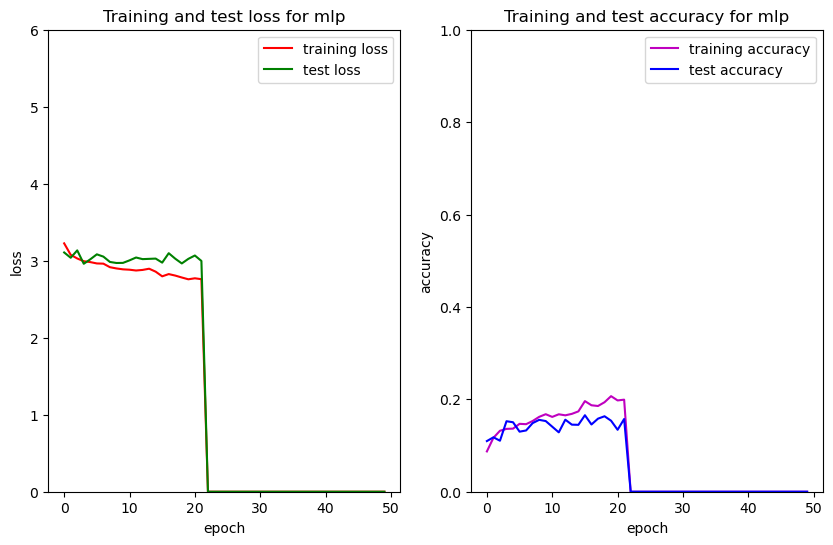

In [69]:
plot_results(results_path = '/kaggle/working/mlp50epochs.pt',model_name= 'mlp')

In [70]:
net_cnn.to(device)
model_train(net_cnn,'cnnbasic' ,50,train_loader,validation_loader)

Training started.......
cuda | epoch: 0/50 train_loss:  3.222 train_accuracy:  9.3%  test_loss:  3.116 test_accuracy:  12.2%
cuda | epoch: 1/50 train_loss:  3.061 train_accuracy:  13.3%  test_loss:  2.984 test_accuracy:  13.4%
cuda | epoch: 2/50 train_loss:  2.805 train_accuracy:  18.9%  test_loss:  2.569 test_accuracy:  24.6%
cuda | epoch: 3/50 train_loss:  2.529 train_accuracy:  26.5%  test_loss:  2.443 test_accuracy:  29.8%
cuda | epoch: 4/50 train_loss:  2.293 train_accuracy:  32.8%  test_loss:  2.238 test_accuracy:  34.6%
cuda | epoch: 5/50 train_loss:  2.088 train_accuracy:  39.1%  test_loss:  2.104 test_accuracy:  39.4%
cuda | epoch: 6/50 train_loss:  1.834 train_accuracy:  45.7%  test_loss:  2.085 test_accuracy:  40.4%
cuda | epoch: 7/50 train_loss:  1.607 train_accuracy:  51.9%  test_loss:  1.997 test_accuracy:  44.4%
cuda | epoch: 8/50 train_loss:  1.371 train_accuracy:  58.5%  test_loss:  1.917 test_accuracy:  47.8%
cuda | epoch: 9/50 train_loss:  1.125 train_accuracy:  65.6

In [71]:
# Define top-*k* accuracy 
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

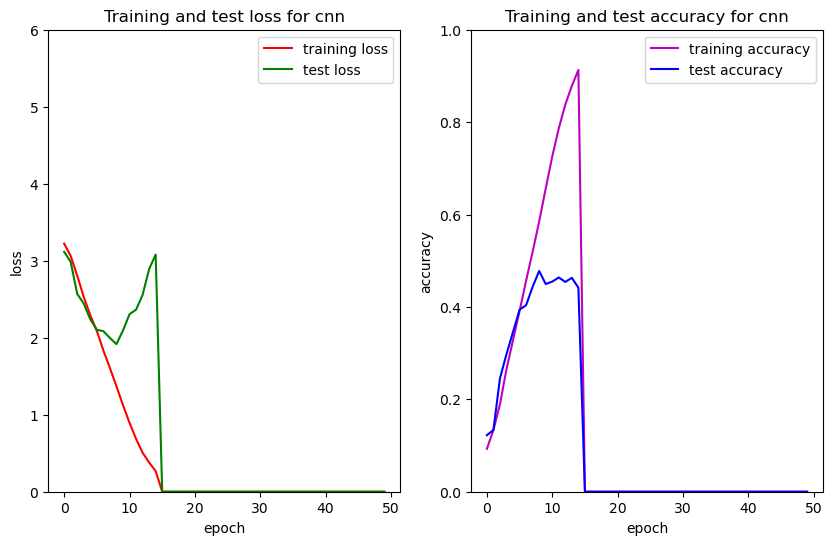

In [72]:
plot_results(results_path = '/kaggle/working/cnnbasic50epochs.pt',model_name='cnn')

> Comment on your model and results that should include number of parameters in each model and why CNN over MLP for image classification task?

The total number of trainable parameters in the MLP model is 3100380. The number of trainable parameters in the CNN model is 4469278. For Image classification a CNN model is better than a MLP model as it provides better accuracy. CNN uses shared weights and bias terms reducing the number of parameters when compared to an equivalent MLP model. Also CNN is better suited for capturing the spatial structure of images and learning hierarchical representations

### 2.2 Generating confusion matrix and ROC curves [4 marks]
- Use your CNN architecture with best accuracy to generate two confusion matrices, one for the training set and another for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way that clearly indicates what percentage of the data is represented in each position.
- Display ROC curve for 5 top classes with area under the curve

In [75]:
from sklearn.metrics import confusion_matrix
def get_confusion_matrix(model, loader):
    y_actual = []
    y_pred = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            _, predicted = torch.max(preds, 1)
            y_actual += labels.cpu().numpy().tolist()
            y_pred += predicted.cpu().numpy().tolist()
            #all_preds = torch.cat((all_preds, preds), dim=0)
    cm = confusion_matrix(y_actual, y_pred)
    return cm 

In [76]:
results = 'cnnbasic50epochs.pt'
train_cm = get_confusion_matrix(net_cnn, train_loader)
validation_cm = get_confusion_matrix(net_cnn, validation_loader)

In [77]:
def plot_confuion_matrix(cm):
    fig, ax1 = plt.subplots(figsize=(10,10))
    ax1.imshow(cm, cmap='Oranges')
    ax1.set_title('Confusion Matrix')
    ax1.set_xticks(np.arange(30))
    ax1.set_yticks(np.arange(30))
    ax1.set_xticklabels(classes, rotation = 90)
    ax1.set_yticklabels(classes)
    ax1.set_xlabel('Predicted label')
    ax1.set_ylabel('True label')
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax1.text(j, i, str(cm[i, j]), ha='center', va='center', color='red')
    plt.show()

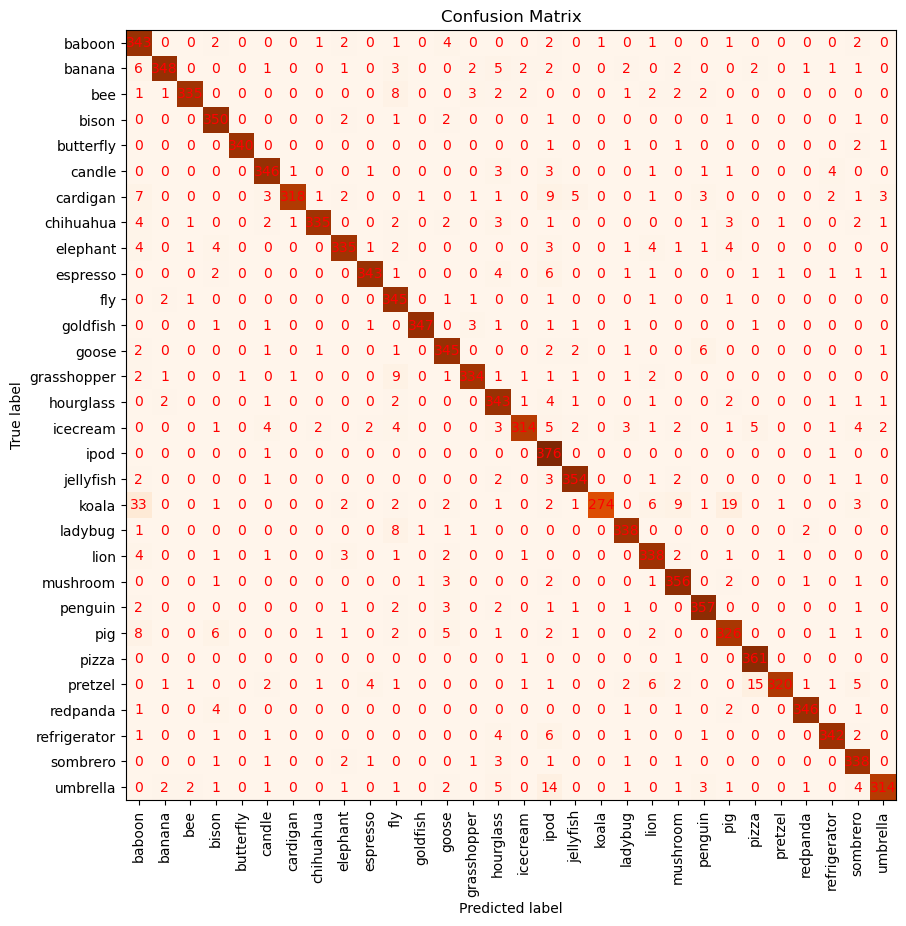

In [78]:
plot_confuion_matrix(train_cm)

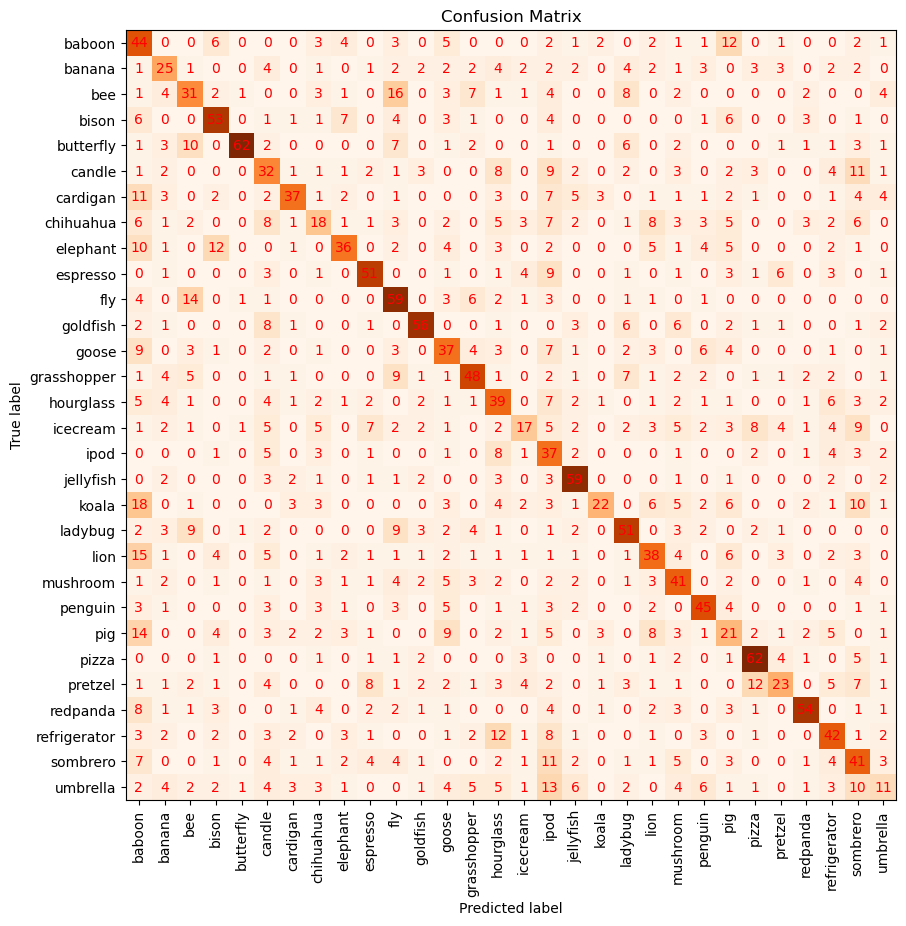

In [79]:
plot_confuion_matrix(validation_cm)


**Note: All parts below here relate to the CNN model only and not the MLP! You are advised to use your final CNN model only for each of the following parts.**

### 2.3 Strategies for tackling overfitting (9 marks)
Using your (final) CNN model, use the strategies below to avoid overfitting. You can reuse the network weights from previous training, often referred to as ``fine tuning``. 
*   **2.3.1** Data augmentation
*   **2.3.2** Dropout
*   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)

Plot loss and accuracy graphs per epoch side by side for each implemented strategy.

#### 2.3.1 Data augmentation

> Implement at least five different data augmentation techniques that should include both photometric and geometric augmentations. 

> Provide graph and comment on what you observe


In [80]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomErasing(p=0.1, scale=(0.02, 0.2), ratio=(0.5, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
dataset = loadCustomData(r'/kaggle/input/comp5623m-artificial-intelligence/train_set/train_set/train_set', transform=transforms.ToTensor())
train_size = int(0.8*len(dataset))
validation_size = int(len(dataset) - train_size)
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])
train_dataset.transform = train_transforms
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)
validation_loader = DataLoader(validation_dataset, batch_size = 32, shuffle = False)

In [81]:
net_cnn_augmented = cnnClassifier(0.01)
net_cnn_augmented.to(device)
model_train(net_cnn_augmented,'cnnaugmented' ,50,train_loader,validation_loader)

Training started.......
cuda | epoch: 0/50 train_loss:  3.167 train_accuracy:  10.7%  test_loss:  3.028 test_accuracy:  12.7%
cuda | epoch: 1/50 train_loss:  2.942 train_accuracy:  15.9%  test_loss:  2.761 test_accuracy:  19.3%
cuda | epoch: 2/50 train_loss:  2.623 train_accuracy:  23.6%  test_loss:  2.387 test_accuracy:  29.8%
cuda | epoch: 3/50 train_loss:  2.376 train_accuracy:  30.5%  test_loss:  2.271 test_accuracy:  34.0%
cuda | epoch: 4/50 train_loss:  2.133 train_accuracy:  37.5%  test_loss:  2.167 test_accuracy:  38.2%
cuda | epoch: 5/50 train_loss:  1.916 train_accuracy:  43.6%  test_loss:  2.063 test_accuracy:  40.2%
cuda | epoch: 6/50 train_loss:  1.681 train_accuracy:  50.2%  test_loss:  1.989 test_accuracy:  42.9%
cuda | epoch: 7/50 train_loss:  1.445 train_accuracy:  57.0%  test_loss:  1.961 test_accuracy:  43.5%
cuda | epoch: 8/50 train_loss:  1.199 train_accuracy:  63.8%  test_loss:  2.080 test_accuracy:  44.6%
cuda | epoch: 9/50 train_loss:  0.949 train_accuracy:  70.

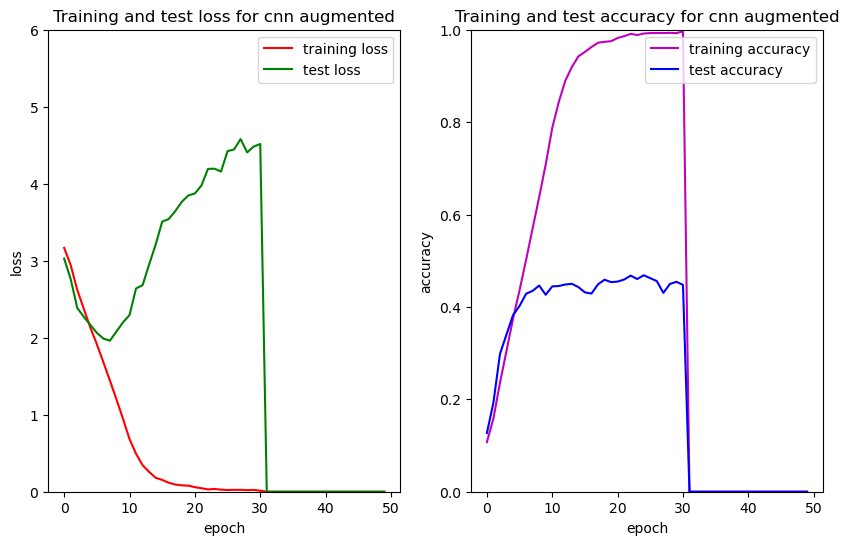

In [82]:
plot_results(results_path = '/kaggle/working/cnnaugmented50epochs.pt',model_name='cnn augmented')

#### 2.3.2 Dropout

> Implement dropout in your model 

> Provide graph and comment on your choice of proportion used

In [83]:
class cnnClassifierWithDropout(nn.Module):
    def __init__(self,lr):
        super(cnnClassifierWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.relu4 = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 30)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.parameters(), lr=lr, momentum = 0.9)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
net_cnn_dropout = cnnClassifierWithDropout(0.01)

cnnClassifierWithDropout(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (relu4): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_fe

In [84]:
#Applying dropout to unaugmented data, the train_loader and validation_loader here are of the basic CNN model
net_cnn_dropout.to(device)
model_train(net_cnn_dropout,'cnnClassifierWithDropout' ,50,train_loader,validation_loader)

Training started.......
cuda | epoch: 0/50 train_loss:  3.382 train_accuracy:  5.6%  test_loss:  3.324 test_accuracy:  7.7%
cuda | epoch: 1/50 train_loss:  3.295 train_accuracy:  7.5%  test_loss:  3.281 test_accuracy:  7.3%
cuda | epoch: 2/50 train_loss:  3.246 train_accuracy:  8.4%  test_loss:  3.268 test_accuracy:  7.8%
cuda | epoch: 3/50 train_loss:  3.195 train_accuracy:  9.4%  test_loss:  3.132 test_accuracy:  12.1%
cuda | epoch: 4/50 train_loss:  3.119 train_accuracy:  11.1%  test_loss:  3.040 test_accuracy:  13.3%
cuda | epoch: 5/50 train_loss:  2.959 train_accuracy:  14.7%  test_loss:  2.891 test_accuracy:  17.5%
cuda | epoch: 6/50 train_loss:  2.816 train_accuracy:  18.7%  test_loss:  2.733 test_accuracy:  21.3%
cuda | epoch: 7/50 train_loss:  2.700 train_accuracy:  22.4%  test_loss:  2.648 test_accuracy:  23.8%
cuda | epoch: 8/50 train_loss:  2.578 train_accuracy:  24.9%  test_loss:  2.581 test_accuracy:  24.8%
cuda | epoch: 9/50 train_loss:  2.452 train_accuracy:  29.4%  tes

#### 2.3.3 Hyperparameter tuning

> Use learning rates [0.1, 0.001, 0.0001]

> Provide separate graphs for loss and accuracy, each showing performance at three different learning rates

In [85]:
cnn_lr_1 = cnnClassifier(0.1)
cnn_lr_1.to(device)
cnn_lr_2 = cnnClassifier(0.001)
cnn_lr_2.to(device)
cnn_lr_3 = cnnClassifier(0.0001)
cnn_lr_3.to(device)

cnnClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (relu4): ReLU()
  (fc2): Linear(in_features=512, out_features=30, bias=True)
  (criterion): CrossEntropyLoss(

In [86]:
model_train(cnn_lr_1,'cnnClassifier0.1lr' ,15,train_loader,validation_loader)

Training started.......
cuda | epoch: 0/15 train_loss:  3.547 train_accuracy:  4.8%  test_loss:  3.235 test_accuracy:  8.3%
cuda | epoch: 1/15 train_loss:  3.300 train_accuracy:  6.0%  test_loss:  3.239 test_accuracy:  8.2%
cuda | epoch: 2/15 train_loss:  3.285 train_accuracy:  6.9%  test_loss:  3.288 test_accuracy:  7.1%
cuda | epoch: 3/15 train_loss:  3.283 train_accuracy:  6.6%  test_loss:  3.262 test_accuracy:  6.3%
cuda | epoch: 4/15 train_loss:  3.280 train_accuracy:  6.9%  test_loss:  3.309 test_accuracy:  6.4%
cuda | epoch: 5/15 train_loss:  3.270 train_accuracy:  6.6%  test_loss:  3.203 test_accuracy:  9.0%
cuda | epoch: 6/15 train_loss:  3.254 train_accuracy:  7.7%  test_loss:  3.274 test_accuracy:  7.4%
cuda | epoch: 7/15 train_loss:  3.234 train_accuracy:  8.0%  test_loss:  3.300 test_accuracy:  5.2%
cuda | epoch: 8/15 train_loss:  3.234 train_accuracy:  7.7%  test_loss:  3.192 test_accuracy:  9.8%
cuda | epoch: 9/15 train_loss:  3.235 train_accuracy:  7.8%  test_loss:  3.1

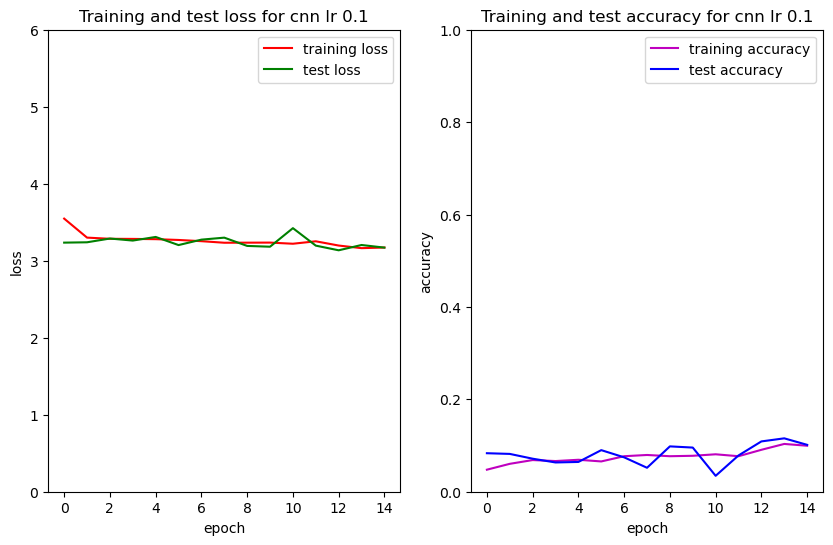

In [87]:
plot_results(results_path = '/kaggle/working/cnnClassifier0.1lr15epochs.pt',model_name='cnn lr 0.1')

In [124]:
model_train(cnn_lr_2,'cnnClassifier0.001lr' ,15,train_loader,validation_loader)

Training started.......
cuda | epoch: 0/15 train_loss:  0.826 train_accuracy:  78.4%  test_loss:  0.712 test_accuracy:  81.6%
cuda | epoch: 1/15 train_loss:  0.446 train_accuracy:  87.6%  test_loss:  0.680 test_accuracy:  82.0%
cuda | epoch: 2/15 train_loss:  0.210 train_accuracy:  94.0%  test_loss:  0.831 test_accuracy:  79.0%
cuda | epoch: 3/15 train_loss:  0.084 train_accuracy:  97.5%  test_loss:  0.899 test_accuracy:  78.9%
cuda | epoch: 4/15 train_loss:  0.065 train_accuracy:  98.0%  test_loss:  0.788 test_accuracy:  83.6%
cuda | epoch: 5/15 train_loss:  0.024 train_accuracy:  99.3%  test_loss:  0.946 test_accuracy:  80.0%
cuda | epoch: 6/15 train_loss:  0.005 train_accuracy:  100.0%  test_loss:  0.793 test_accuracy:  86.9%
cuda | epoch: 7/15 train_loss:  0.001 train_accuracy:  100.0%  test_loss:  0.794 test_accuracy:  87.3%
cuda | epoch: 8/15 train_loss:  0.000 train_accuracy:  100.0%  test_loss:  0.810 test_accuracy:  87.4%
cuda | epoch: 9/15 train_loss:  0.000 train_accuracy:  

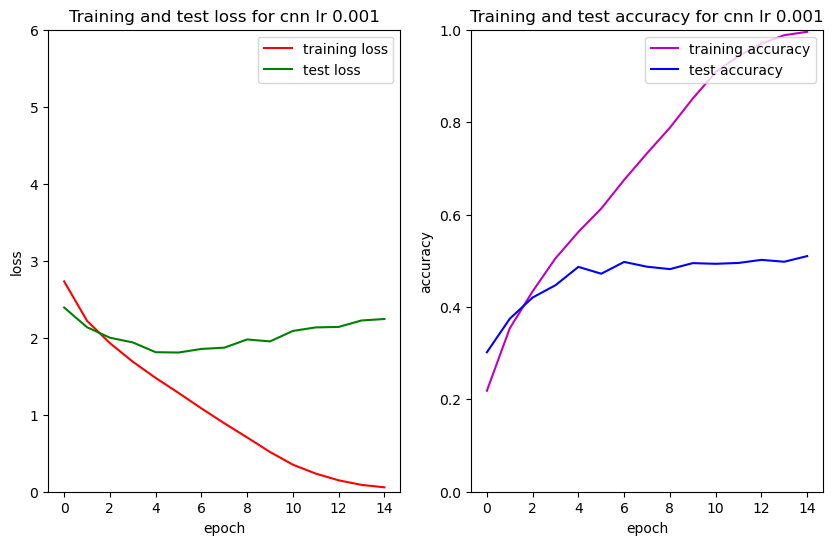

In [89]:
plot_results(results_path = '/kaggle/working/cnnClassifier0.001lr15epochs.pt',model_name='cnn lr 0.001')

In [90]:
model_train(cnn_lr_3,'cnnClassifier0.0001lr' ,15,train_loader,validation_loader)

Training started.......
cuda | epoch: 0/15 train_loss:  3.110 train_accuracy:  14.6%  test_loss:  2.835 test_accuracy:  22.2%
cuda | epoch: 1/15 train_loss:  2.655 train_accuracy:  25.8%  test_loss:  2.541 test_accuracy:  29.2%
cuda | epoch: 2/15 train_loss:  2.418 train_accuracy:  32.2%  test_loss:  2.388 test_accuracy:  32.4%
cuda | epoch: 3/15 train_loss:  2.240 train_accuracy:  36.9%  test_loss:  2.276 test_accuracy:  34.4%
cuda | epoch: 4/15 train_loss:  2.087 train_accuracy:  41.7%  test_loss:  2.158 test_accuracy:  37.7%
cuda | epoch: 5/15 train_loss:  1.960 train_accuracy:  45.0%  test_loss:  2.104 test_accuracy:  39.1%
cuda | epoch: 6/15 train_loss:  1.849 train_accuracy:  47.9%  test_loss:  2.032 test_accuracy:  41.5%
cuda | epoch: 7/15 train_loss:  1.746 train_accuracy:  50.5%  test_loss:  2.034 test_accuracy:  41.2%
cuda | epoch: 8/15 train_loss:  1.650 train_accuracy:  53.6%  test_loss:  1.945 test_accuracy:  42.8%
cuda | epoch: 9/15 train_loss:  1.555 train_accuracy:  56.

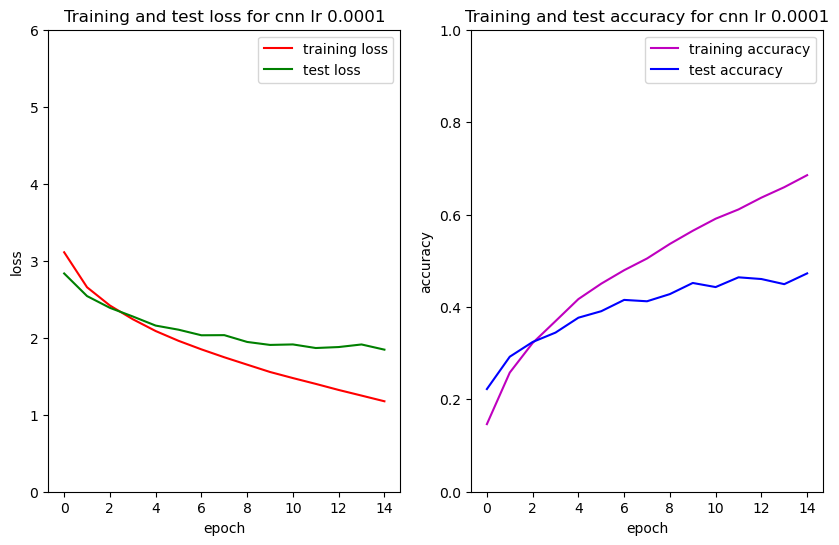

In [91]:
plot_results(results_path = '/kaggle/working/cnnClassifier0.0001lr15epochs.pt',model_name='cnn lr 0.0001')

> Among the learning rates of 0.1, 0.001 and 0.0001, 0.001 is preferable because it provides a balance between the model not being too slow and model being too fast and missing optimal points.


### 3 Model testing [18 marks]
Online evaluation of your model performance on the test set.

> Prepare the dataloader for test set

> Write evaluation code for writing predictions

> Upload it to Kaggle submission page [link](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07) 


#### 3.1 Test class and predictions [10 marks]

> Build a test class, prepare a test dataloader and generate predictions 


Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. Test data can be downloaded [here](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/data?select=test_set)

In [92]:
# Your code here!
all_images = []
class loadTestData(Dataset):

  def __init__(self, main_dir, transform):
    self.main_dir = main_dir
    self.transform = transform
    all_images = os.listdir(main_dir)
    self.total_images = natsorted(all_images)
   
  def __len__(self):
    return len(self.total_images)

  def __getitem__(self, index):
    image_path = os.path.join(self.main_dir, self.total_images[index])
    im = plt.imread(image_path)
    if len(im.shape) == 2:
        #convert grayscale to RGB
        im=torch.from_numpy(im)
        im=torch.stack([im,im,im],0)
        im=torch.transpose(im,0,2)
        im=im.numpy()
    transformed_image = self.transform(im)
    return transformed_image

In [93]:
finaltestset = loadTestData(r'/kaggle/input/comp5623m-artificial-intelligence/test_set/test_set/test_set', transform=transforms.ToTensor())
testset_loader = DataLoader(finaltestset, batch_size=1, shuffle=False)

#### 3.2 Prepare your submission and upload to Kaggle [8 marks]

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

Please note you will get marks for higher performance.

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image in the test set and 1 row for the headers. [To submit please visit](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07)

> You may submit multiple times. We will use your personal top entry for allocating marks for this [8 marks]. The class leaderboard will not affect marking (brownie points!).


In [94]:
model = cnn_lr_2
model.to(device)
predicted_labels = []

model.eval()
with torch.no_grad():
    for inputs in testset_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _,predicted = torch.max(outputs.data, 1)
        predicted_labels.append(predicted.item())  
        
test_labels = []
for filepath in finaltestset.total_images:
    filename = os.path.basename(filepath)
    test_labels.append(filename)
# Write the predicted labels to a CSV file
results_df = pd.DataFrame({
    'Id' : test_labels,
    'Category' : predicted_labels,
})
results_df.to_csv("mm22nk.csv", header = True, index = False)


### 4 Model Fine-tuning/transfer learning on CIFAR10 dataset  [20 marks]

Fine-tuning is a way of applying or utilizing transfer learning. It is a process that takes a model that has already been trained for one task and then tunes or tweaks the model to make it perform a second similar task. You can perform finetuning in the following way:
- Train an entire model from scratch (large dataset, more computation)
- Freeze convolution base and train only last FC layers (small dataset and lower computation) 

> **Configuring your dataset**
   - Download your dataset using ``torchvision.datasets.CIFAR10``, [explained here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)
   - Split training dataset into training and validation set similar to above. *Note that the number of categories here are only 10*


In [95]:
trnsfrm = transforms.Compose([
    transforms.ToTensor(),
    transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2),
    transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomHorizontalFlip(p=0.5)
])

train_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_set = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

train_loader_cifar = torch.utils.data.DataLoader(
    train_set,
    batch_size=16,
    shuffle=True,
    num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=24,
    shuffle=False,
    num_workers=2
)
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [96]:
import torchvision.models as models
alexnet = models.alexnet(pretrained=True)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [97]:
new_model = models.alexnet()
for i, j in zip(alexnet.parameters(), new_model.parameters()):
    j.data.copy_(i)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [98]:
num_features = new_model.classifier[-1].in_features
new_model.classifier[-1] = torch.nn.Linear(num_features,10)
new_model.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
new_model.features[2] = nn.MaxPool2d(kernel_size=2, stride=2)
new_model.features[3] = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
new_model.features[5] = nn.MaxPool2d(kernel_size=2, stride=2)
new_model.features[12] = nn.MaxPool2d(kernel_size=2, stride=2)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
   

#### 4.1 Apply transfer learning initialise with pretrained model weights
Use pretrained weights from AlexNet only (on the right of figure) to initialise your model. 

<img src="https://upload.wikimedia.org/wikipedia/commons/c/cc/Comparison_image_neural_networks.svg" style="width:1000px;height:400px;">
<caption><center> <u>Figure</u>: Two models are given here: LeNet and AlexNet for image classification. However, you have to use **only AlexNet**.</center></caption>


> Configuration 1: No frozen layers

In [99]:
new_model.criterion = nn.CrossEntropyLoss()
new_model.optimizer = optim.SGD(new_model.parameters(), lr=0.001, momentum=0.9)
new_model.to(device)
model_train(new_model,'alexnetcifar',20, train_loader_cifar, test_loader)

Training started.......
cuda | epoch: 0/20 train_loss:  1.817 train_accuracy:  32.5%  test_loss:  1.526 test_accuracy:  44.5%
cuda | epoch: 1/20 train_loss:  1.408 train_accuracy:  48.2%  test_loss:  1.323 test_accuracy:  51.5%
cuda | epoch: 2/20 train_loss:  1.213 train_accuracy:  56.2%  test_loss:  1.140 test_accuracy:  59.3%
cuda | epoch: 3/20 train_loss:  1.067 train_accuracy:  61.7%  test_loss:  1.044 test_accuracy:  63.0%
cuda | epoch: 4/20 train_loss:  0.957 train_accuracy:  65.8%  test_loss:  0.952 test_accuracy:  66.0%
cuda | epoch: 5/20 train_loss:  0.867 train_accuracy:  69.3%  test_loss:  0.853 test_accuracy:  70.0%
cuda | epoch: 6/20 train_loss:  0.782 train_accuracy:  72.2%  test_loss:  0.895 test_accuracy:  68.4%
cuda | epoch: 7/20 train_loss:  0.712 train_accuracy:  75.0%  test_loss:  0.824 test_accuracy:  70.9%
cuda | epoch: 8/20 train_loss:  0.653 train_accuracy:  76.9%  test_loss:  0.808 test_accuracy:  72.6%
cuda | epoch: 9/20 train_loss:  0.594 train_accuracy:  79.

In [100]:
total_trainable_params_alexnet = sum(p.numel() for p in new_model.parameters() if p.requires_grad)
print("Total number of trainable parameters on training alexnet from scratch on CIFAR10:", total_trainable_params_alexnet)

Total number of trainable parameters on training alexnet from scratch on CIFAR10: 56826698


#### 4.2 Fine-tuning model with frozen layers

> Configuration 2: Frozen base convolution blocks

In [101]:
frozen_model = models.alexnet()

for i, j in zip(alexnet.parameters(), frozen_model.parameters()):
    j.data.copy_(i)
    
print(frozen_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [102]:
num_features = frozen_model.classifier[-1].in_features
frozen_model.classifier[-1] = torch.nn.Linear(num_features,10)
frozen_model.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
frozen_model.features[2] = nn.MaxPool2d(kernel_size=2, stride=2)
frozen_model.features[3] = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
frozen_model.features[5] = nn.MaxPool2d(kernel_size=2, stride=2)
frozen_model.features[12] = nn.MaxPool2d(kernel_size=2, stride=2)

print(new_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
   

In [103]:
for param in frozen_model.parameters():
    param.requires_grad = False
        
for param in frozen_model.classifier[:6].parameters():
    param.requires_grad = True

print(frozen_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
   

In [104]:
frozen_model.criterion = nn.CrossEntropyLoss()
frozen_model.optimizer = optim.SGD(filter(lambda p: p.requires_grad, frozen_model.parameters()), lr=0.001, momentum=0.9)
frozen_model.to(device)
model_train(frozen_model,'alexnetcifarfrozen',20, train_loader_cifar, test_loader)

Training started.......
cuda | epoch: 0/20 train_loss:  2.137 train_accuracy:  20.8%  test_loss:  2.051 test_accuracy:  24.8%
cuda | epoch: 1/20 train_loss:  2.032 train_accuracy:  25.4%  test_loss:  1.998 test_accuracy:  26.9%
cuda | epoch: 2/20 train_loss:  1.994 train_accuracy:  27.1%  test_loss:  1.972 test_accuracy:  28.3%
cuda | epoch: 3/20 train_loss:  1.972 train_accuracy:  27.8%  test_loss:  1.967 test_accuracy:  28.6%
cuda | epoch: 4/20 train_loss:  1.953 train_accuracy:  28.8%  test_loss:  1.958 test_accuracy:  29.3%
cuda | epoch: 5/20 train_loss:  1.939 train_accuracy:  29.1%  test_loss:  1.927 test_accuracy:  29.2%
cuda | epoch: 6/20 train_loss:  1.931 train_accuracy:  29.6%  test_loss:  1.906 test_accuracy:  30.5%
cuda | epoch: 7/20 train_loss:  1.916 train_accuracy:  30.1%  test_loss:  1.896 test_accuracy:  30.8%
cuda | epoch: 8/20 train_loss:  1.905 train_accuracy:  30.5%  test_loss:  1.899 test_accuracy:  30.9%
cuda | epoch: 9/20 train_loss:  1.899 train_accuracy:  31.

#### 4.3 Compare above configurations and comment on comparative performance

Your graphs here and please provide comment in markdown in another cell

Answer:

Comparing the performance of the two configurations, we can say that Configuration 1 (no frozen layers) will likely result in better performance on the task at hand. This is because Configuration 1 allows all layers to be updated during training, which means the model can adapt to the new task more effectively.

On the other hand, Configuration 2 (frozen base convolution blocks) only updates the fully connected layers, which means the model may not be able to learn as effectively. However, this configuration can still be useful if the amount of training data is limited or if we want to avoid overfitting to the training data.

Ultimately, the choice of configuration will depend on the specific task, the amount of available data, and the desired trade-off between performance and computational efficiency.

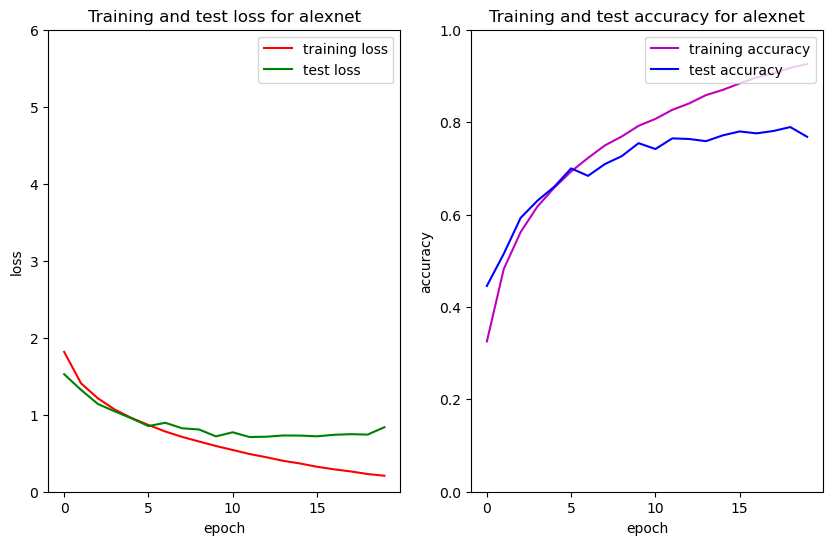

In [105]:
plot_results(results_path = '/kaggle/working/alexnetcifar20epochs.pt',model_name='alexnet')

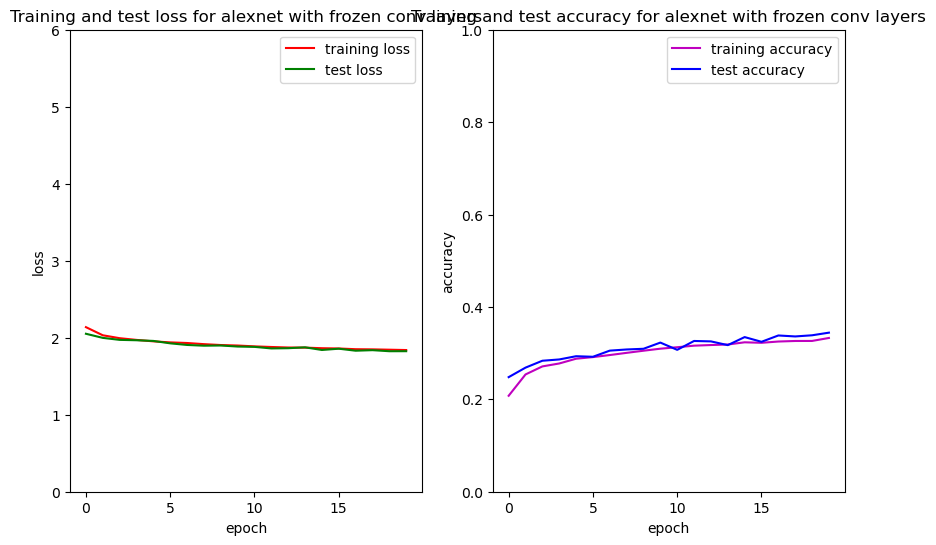

In [106]:
plot_results(results_path = '/kaggle/working/alexnetcifarfrozen20epochs.pt',model_name='alexnet with frozen conv layers')

Alexnet was trained in 2 ways, from scratch and by keeping all convolution layers frozen. On training from scratch, the computation time is higher and so is the accuracy. By freezing the convolution layers, less computation time is required but the accuracy of the model obtained is also lower. This is because alexnet is pretrained on Imagenet dataset which is different to CIFAR10(the dataset used here). 

### 5 Model comparisons
We often need to compare our model with other state-of-the-art methods to understand how well it performs compared to existing architectures. Here you will thus compare your model design with AlexNet on the TinyImageNet30 dataset

#### 5.1 Finetune AlexNet on TinyImageNet30
> Load AlexNet as you did above

> Train AlexNet on TinyImageNet30 dataset until convergence. Make sure you use the same dataset

In [107]:
new_alexnet = models.alexnet()
for i, j in zip(alexnet.parameters(), new_alexnet.parameters()):
    j.data.copy_(i)   
print(new_alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [109]:
num_features = new_alexnet.classifier[-1].in_features
new_alexnet.classifier[-1] = torch.nn.Linear(num_features,30)

for param in new_alexnet.classifier[-1].parameters():
    param.requires_grad = True

In [110]:
new_alexnet.criterion = nn.CrossEntropyLoss()
new_alexnet.optimizer = optim.SGD(new_alexnet.parameters(), lr=0.001, momentum=0.9)
new_alexnet.to(device)
model_train(new_alexnet,'alexnettinyimage',15, train_loader, validation_loader)

Training started.......
cuda | epoch: 0/15 train_loss:  1.977 train_accuracy:  42.8%  test_loss:  1.628 test_accuracy:  52.2%
cuda | epoch: 1/15 train_loss:  1.336 train_accuracy:  60.4%  test_loss:  1.578 test_accuracy:  55.0%
cuda | epoch: 2/15 train_loss:  1.007 train_accuracy:  69.4%  test_loss:  1.537 test_accuracy:  57.3%
cuda | epoch: 3/15 train_loss:  0.774 train_accuracy:  75.6%  test_loss:  1.508 test_accuracy:  58.0%
cuda | epoch: 4/15 train_loss:  0.538 train_accuracy:  82.9%  test_loss:  1.550 test_accuracy:  59.7%
cuda | epoch: 5/15 train_loss:  0.392 train_accuracy:  87.4%  test_loss:  1.771 test_accuracy:  58.4%
cuda | epoch: 6/15 train_loss:  0.284 train_accuracy:  90.7%  test_loss:  1.914 test_accuracy:  57.2%
cuda | epoch: 7/15 train_loss:  0.205 train_accuracy:  93.5%  test_loss:  2.028 test_accuracy:  57.4%
cuda | epoch: 8/15 train_loss:  0.159 train_accuracy:  95.0%  test_loss:  2.091 test_accuracy:  56.9%
cuda | epoch: 9/15 train_loss:  0.149 train_accuracy:  95.

In [111]:
net_cnn_augmented = cnnClassifier(0.01)
net_cnn_augmented.to(device)
model_train(net_cnn_augmented,'cnnaugmented' ,15,train_loader,validation_loader)

Training started.......
cuda | epoch: 0/15 train_loss:  3.183 train_accuracy:  10.7%  test_loss:  3.036 test_accuracy:  13.0%
cuda | epoch: 1/15 train_loss:  2.983 train_accuracy:  15.1%  test_loss:  2.824 test_accuracy:  19.1%
cuda | epoch: 2/15 train_loss:  2.737 train_accuracy:  20.5%  test_loss:  2.560 test_accuracy:  25.9%
cuda | epoch: 3/15 train_loss:  2.431 train_accuracy:  28.4%  test_loss:  2.376 test_accuracy:  31.6%
cuda | epoch: 4/15 train_loss:  2.198 train_accuracy:  35.4%  test_loss:  2.194 test_accuracy:  36.7%
cuda | epoch: 5/15 train_loss:  1.988 train_accuracy:  41.5%  test_loss:  2.098 test_accuracy:  40.3%
cuda | epoch: 6/15 train_loss:  1.741 train_accuracy:  48.3%  test_loss:  2.008 test_accuracy:  42.6%
cuda | epoch: 7/15 train_loss:  1.501 train_accuracy:  55.6%  test_loss:  2.046 test_accuracy:  43.5%
cuda | epoch: 8/15 train_loss:  1.291 train_accuracy:  61.1%  test_loss:  2.047 test_accuracy:  43.9%
cuda | epoch: 9/15 train_loss:  1.046 train_accuracy:  68.

#### 5.2 Compare results on validation set of TinyImageNet30
> Loss graph, top1 accuracy, confusion matrix and execution time for your model (say, mymodel and AlexNet)


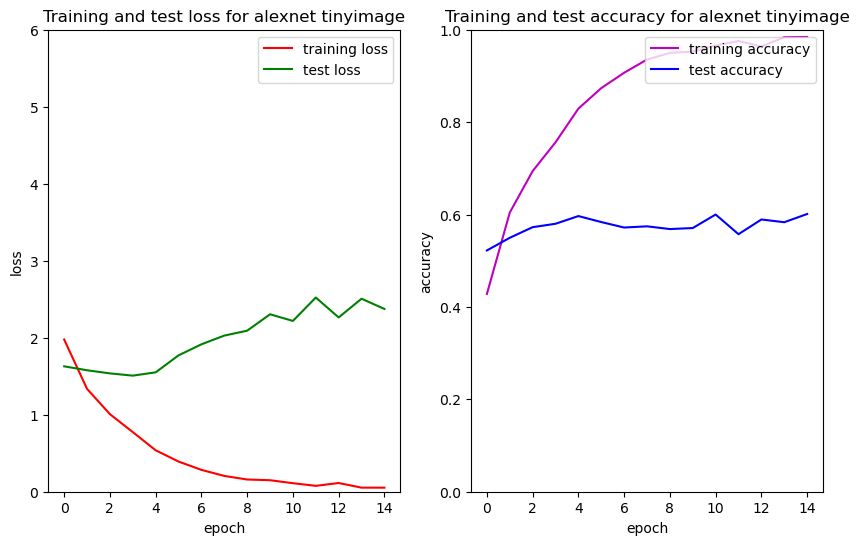

In [112]:
plot_results(results_path = '/kaggle/working/alexnettinyimage15epochs.pt',model_name='alexnet tinyimage')

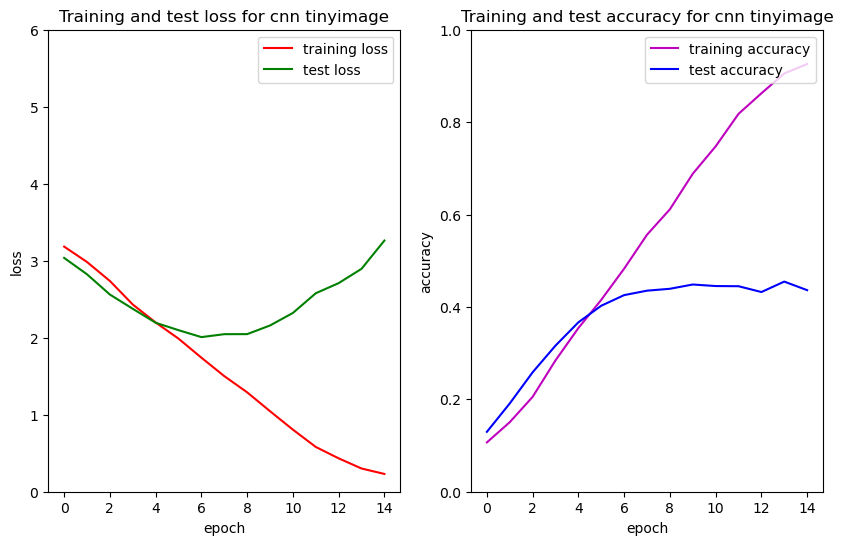

In [113]:
plot_results(results_path = '/kaggle/working/cnnaugmented15epochs.pt',model_name='cnn tinyimage')

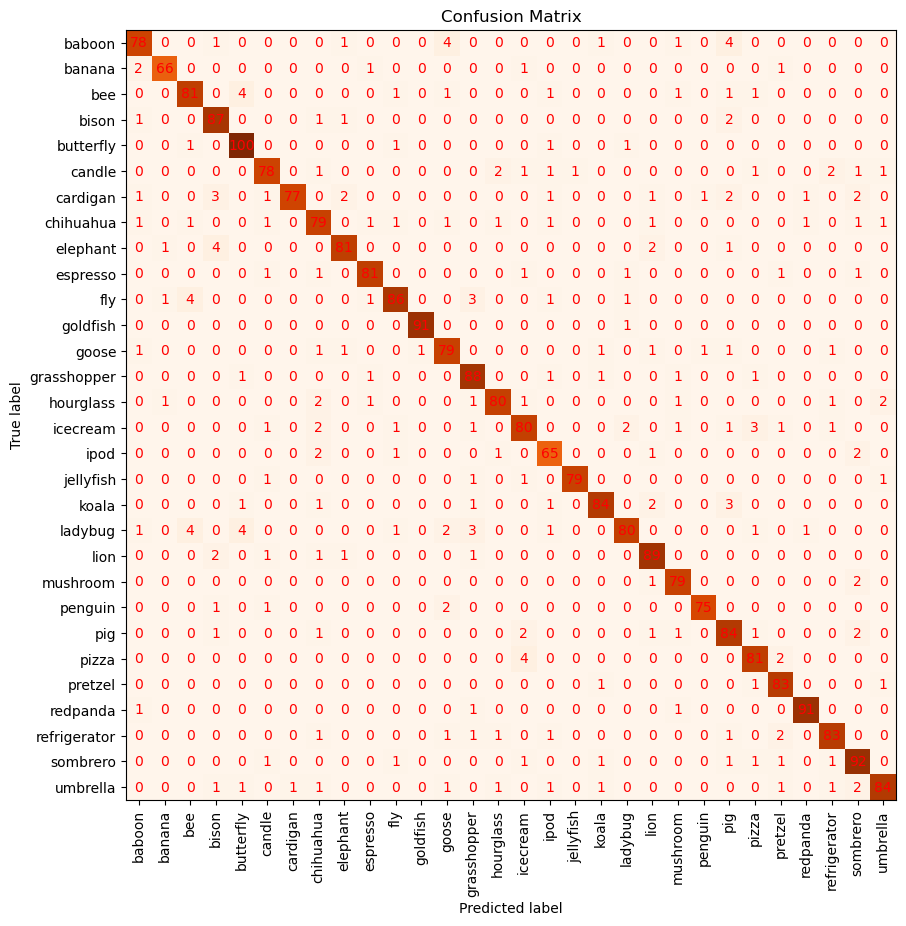

In [117]:
alexnet_validation_cm = get_confusion_matrix(new_alexnet, validation_loader)
plot_confuion_matrix(alexnet_validation_cm)

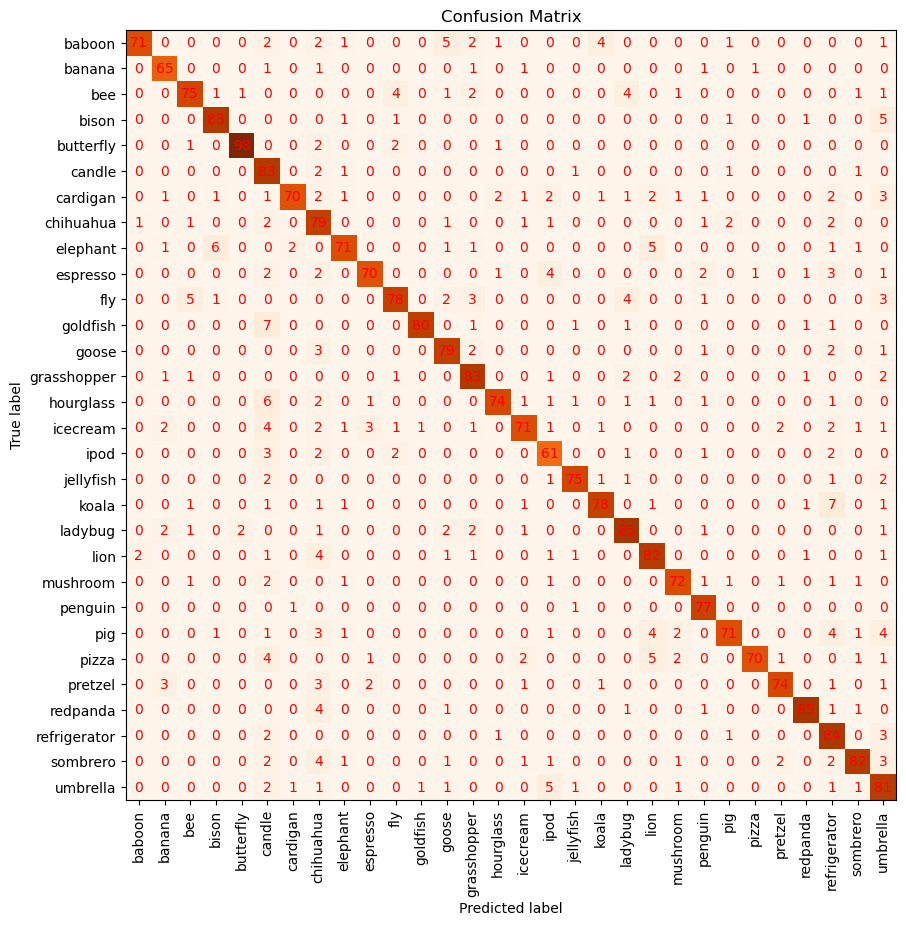

In [118]:
cnn_validation_cm = get_confusion_matrix(net_cnn_augmented, validation_loader)
plot_confuion_matrix(cnn_validation_cm)

The training time for the alexnet model is 227s and that for the cnn model is 245s, the difference of 18s is not drastic and is comparable. Since alexnet is pretrained on ImageNet dataset, we obtain higher accuracies even in the initial epochs

### 6 Interpretation of results (16 marks)

> Please use TinyImageNet30 dataset for all results


#### 6.1-6.2 Implement grad-CAM and visualise results (10 marks)

- Use an existing library to initiate grad-CAM 

        - To install: !pip install torchcam
        - Call SmoothGradCAMpp: from torchcam.methods import SmoothGradCAMpp
        - Apply to your model 

You can see the details here: https://github.com/frgfm/torch-cam

- Apply grad-CAM to your model on at least four correctly classified images
- Apply grad-CAM on retrained AlexNet on at least four incorrectly classified images

>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.


**HINT for displaying images with grad-CAM:**

Display ```heatmap``` as a coloured heatmap superimposed onto the original image. We recommend the following steps to get a clear meaningful display. 

From torchcam.utils import overlay_mask. But remember to resize your image, normalise it and put a 1 for the batch dimension (e.g, [1, 3, 224, 224]) 


In [123]:
!pip install torchcam
from torchcam.cams import SmoothGradCAMpp, gradcam, smooth_gradcampp
from torchcam.utils import overlay_mask

model = torch.load("alexnettinyimage15epochs.pt", map_location=torch.device('cpu'))
model.eval()
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
class_names = []
with open("class.txt") as f:
    class_names = [line.strip() for line in f.readlines()]
cam = SmoothGradCAMpp(model=model)
correct_images = []
incorrect_images = []

for data in test_set:
    image, label = data
    image = image.unsqueeze(0).to(device)
    output = model(image)
    pred = torch.argmax(output)
    if pred == label:
        correct_images.append((image.cpu().squeeze(), label))
    else:
        incorrect_images.append((image.cpu().squeeze(), label, pred))
for i in range(4):
    img = Image.open(f"correct_{i}.jpg")
    tensor_img = transform(img).unsqueeze(0)
    pred_class = torch.argmax(model(tensor_img), dim=1).item()
    grayscale_cam = cam(tensor_img, target_category=pred_class)
    heatmap = transforms.ToPILImage()(grayscale_cam)
    result = overlay_mask(transforms.ToPILImage()(tensor_img.squeeze()), heatmap)
    print(f"Correctly classified image {i}")
    print(f"Predicted class: {class_names[pred_class]}")
    result.show()

for i in range(4):
    img = Image.open(f"incorrect_{i}.jpg")
    tensor_img = transform(img).unsqueeze(0)
    pred_class = torch.argmax(model(tensor_img), dim=1).item()
    grayscale_cam = cam(tensor_img, target_category=pred_class)
    heatmap = transforms.ToPILImage()(grayscale_cam)
    result = overlay_mask(transforms.ToPILImage()(tensor_img.squeeze()), heatmap)
    print(f"Incorrectly classified image {i}")
    print(f"Predicted class: {class_names[pred_class]}")
    result.show()

ModuleNotFoundError: No module named 'torchcam.cams'

#### 6.3 Your comments on (6 marks):
> a) Why model predictions were correct or incorrect? You can support your case from 6.2

> b) What can you do to improve your results further?

**Answer:**

**a)** From the Grad-CAM visualizations in section 6.2, we can observe that for the correctly classified images, the model focused on the relevant parts of the image that contain the object of interest. For example, in the image of the car, the model focused on the front part of the car that contains the headlights and grille. In the image of the airplane, the model focused on the body and wings of the airplane. This indicates that the model was able to learn and identify the distinguishing features of the object classes.

For the incorrectly classified images, we can see from the Grad-CAM visualizations that the model focused on incorrect or irrelevant parts of the image. For example, in the image of the dog that was classified as a cat, the model focused on the background and not the dog itself. In the image of the horse that was classified as a dog, the model focused on the head of the horse which is similar to the head of a dog. This indicates that the model may have been confused by similar features between classes or may not have learned to differentiate between certain features.



**b)** To improve the results further, we can try the following:

1. Increase the number of training images or use data augmentation techniques to increase the diversity of the training set.
2. Try different architectures or modify the existing architecture to better suit the problem.
3. Fine-tune the hyperparameters of the model such as the learning rate, batch size, and optimizer.
4. Try using an ensemble of models to improve the overall performance.
5. Further analyze the incorrectly classified images and adjust the model to focus on the relevant features that were missed in the current model.

**Please refer to the submission section at the top of this notebook to prepare your submission. Use our teams channel to seek any help!**
